In [1]:
cd '/content/drive/MyDrive/Face Age Regression/dataset'

/content/drive/.shortcut-targets-by-id/1CicvpTOJTS5QdXTfCskdYDicM1Cq3ds3/Face Age Regression/dataset


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [ ]:
# !kaggle datasets download -d jangedoo/utkface-new
# !unzip utkface-new.zip

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf
import cv2
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

**hyper parameters**

In [3]:
epochs=20
width=height=224
batch_size=1
lr=0.001

# Dataset

In [4]:
images=[]  #X
ages=[]    #Y

for image_name in os.listdir('crop_part1')[:9000]:
  parts=image_name.split('_')
  ages.append(int(parts[0]))

  image=cv2.imread(f'crop_part1/{image_name}')
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  images.append(image)

In [5]:
images=pd.Series(images,name='Images')
ages=pd.Series(ages,name='Ages')
df=pd.concat([images,ages],axis=1)
df.head()

,Images,Ages
0,"[[[179, 149, 111], [184, 154, 116], [192, 162,...",57
1,"[[[85, 91, 91], [83, 89, 89], [80, 84, 83], [7...",50
2,"[[[0, 1, 0], [0, 1, 0], [1, 3, 2], [2, 4, 3], ...",69
3,"[[[49, 32, 24], [46, 32, 23], [43, 33, 21], [4...",8
4,"[[[28, 24, 23], [30, 26, 25], [32, 27, 24], [3...",8


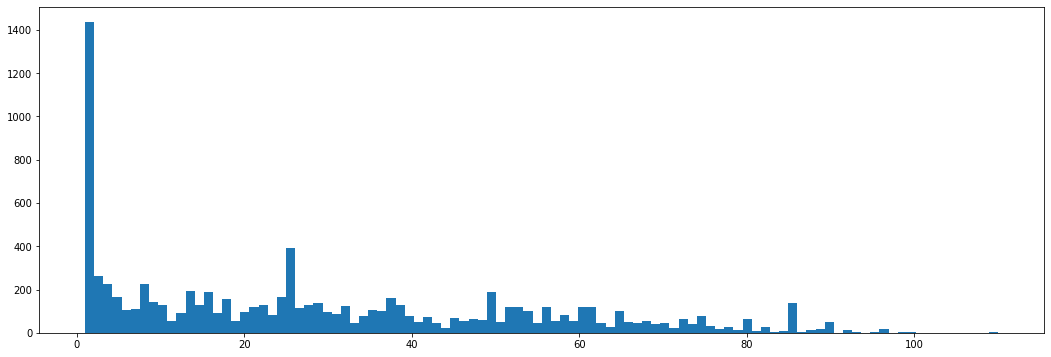

In [6]:
plt.figure(figsize=(18,6))
plt.hist(df['Ages'],bins=100)
plt.show()

In [7]:
under_4=[]
for i in range(len(df)):
  if df['Ages'].iloc[i] <=4:
    under_4.append(df.iloc[i])
under_4=pd.DataFrame(under_4)
under_4=under_4.sample(frac=0.3)

up_4=df[df['Ages']>4]
df=pd.concat([under_4,up_4])

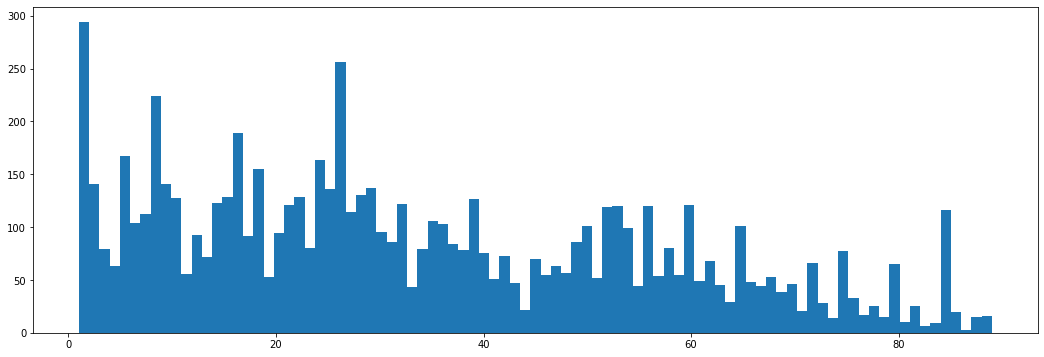

In [8]:
df=df[df['Ages']<90]
plt.figure(figsize=(18,6))
plt.hist(df['Ages'],bins=89)
plt.show()

In [9]:
X=[]
Y=[]
for i in range(len(df)):
  df['Images'].iloc[i]=cv2.resize(df['Images'].iloc[i],(width,height))
  X.append(df['Images'].iloc[i])
  Y.append(df['Ages'].iloc[i])

X=np.array(X)
Y=np.array(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [10]:
x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.2)

In [11]:
class CustomDataset(Dataset):
  def __init__(self,x,y,transform=None):
    super().__init__()
    self.image = x
    self.target = y
    self.transform=transform

  def __getitem__(self,index):
    x = self.image[index]
    y = self.target[index]
    
    if self.transform:
      x = self.transform(x)

    return x,y

  def __len__(self):
    return len(self.image)

In [12]:
transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToPILImage(),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.Normalize((0),(1))
])

dataset=CustomDataset(x_train,y_train,transform=transform)
train_size=int(len(dataset)*0.8)
val_size=len(dataset)-train_size
train_data ,val_data = torch.utils.data.random_split(dataset,[train_size,val_size])

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [13]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
    self.cnn1_bn = nn.BatchNorm2d(32)
    self.cnn2= nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1) 
    self.cnn2_bn = nn.BatchNorm2d(64)
    self.cnn3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
    self.cnn3_bn = nn.BatchNorm2d(128)
    self.cnn4= nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1) 
    self.cnn4_bn = nn.BatchNorm2d(256)

    self.fc1= nn.Linear(50176,128)
    self.fc2= nn.Linear(128,1)

  def forward(self, x):
    x = self.cnn1(x)
    x = self.cnn1_bn(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=(2,2))

    x = self.cnn2(x)
    x = self.cnn2_bn(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=(2,2))

    x = self.cnn3(x)
    x = self.cnn3_bn(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=(2,2))

    x = self.cnn4(x)
    x = self.cnn4_bn(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=(2,2))

    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = torch.dropout(x,0.3,train=True)
    x = self.fc2(x)
    # x = torch.softmax(x, dim=1)

    return x

In [14]:
device = torch.device('cuda')
model = Model()
model = model.to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
loss_function = nn.MSELoss()

In [16]:
def calc_acc(preds,labels):
  _,preds_max = torch.max(preds,1)
  acc = torch.sum(preds_max == labels.data, dtype=torch.float64) / len(preds)
  return acc

In [17]:
def train(model, train_data_loader,epoch):
  model.train(True)
  train_loss=0
  train_acc=0
  for images,labels in tqdm(train_data_loader):
    images=images.to(torch.float32)
    labels=labels.to(torch.float32)
    images=images.to(device)
    labels=labels.to(device)
    optimizer.zero_grad()
    preds_train = model(images)
   
    loss_train=loss_function(preds_train,labels) # loss_train
    loss_train.backward()
    optimizer.step()

    train_loss += loss_train
    train_acc += calc_acc(preds_train,labels)
    
  total_loss = train_loss/len(train_data_loader)
  total_acc = train_acc/len(train_data_loader)
  print(f"loss_train:{total_loss},accuracy_train:{total_acc}")


In [18]:
def test(model, val_data_loader,epoch):
  model.eval()
  test_loss=0.0
  test_acc=0.0
  for images,labels in tqdm(val_data_loader):    
    images=images.to(device)
    labels=labels.to(device)
    
    preds_test = model(images)

    loss_test=loss_function(preds_test,labels) 

    test_loss += loss_test
    test_acc += calc_acc(preds_test,labels)

  total_loss = test_loss/len(val_data_loader)
  total_acc = test_acc/len(val_data_loader)
  print(f"loss_eval:{total_loss},accuracy_eval:{total_acc}")

In [19]:
for epoch in range(epochs):
  print(f'Epoch:{epoch}')
  train(model, train_data_loader, epoch)
  test(model, val_data_loader, epoch)

Epoch:0


  0%|          | 0/4714 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 4714/4714 [01:12<00:00, 65.17it/s]


loss_train:427.4591064453125,accuracy_train:0.0


 28%|██▊       | 331/1179 [00:01<00:04, 207.42it/s]


RuntimeError: ignored

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Face Age Regression/age_weight.pth")